In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [68]:
%matplotlib inline

from dolfin import FunctionSpace, Function, assemble, UnitSquareMesh, TrialFunction, nabla_div, \
                   TestFunction, inner, nabla_grad, as_backend_type, dx, DirichletBC, Constant, plot, cells, \
                   CellFunction, interactive, vertices, dot, Measure, CellSize
import numpy as np
from scipy.sparse import csr_matrix
import time
import os
import matplotlib.pyplot as plt
os.chdir("../../../utils")
from tictoc import TicToc
os.chdir("../application/bayes/Notebooks")



mesh = UnitSquareMesh(2, 2)

V = FunctionSpace(mesh, 'CG', 3)

bc_fun = Function(V)


def u0_boundary(x, on_boundary):
    return on_boundary

bc_indic = DirichletBC(V, Constant(1.0), u0_boundary)
bc_indic.apply(bc_fun.vector())

In [4]:
def get_dof2patch_dof_list(fs):
    dm = fs.dofmap()
    dofs = dm.dofs()
    cell2dof = [dm.cell_dofs(i) for i in range(fs.mesh().num_cells())]
    patch_list = []
    for d in dofs:
        patch = []
        for c in cell2dof:
            if not d in c:
                continue
            patch.append(c)
        patch_list.append(patch)
    # print patch_list
    dof2patch_dofs = []
    for patch_dofs in patch_list:
        curr_dofs = []
        for patch in patch_dofs:
            for dof in patch:
                if dof not in curr_dofs:
                    curr_dofs.append(dof)
        dof2patch_dofs.append(curr_dofs)
    return dof2patch_dofs

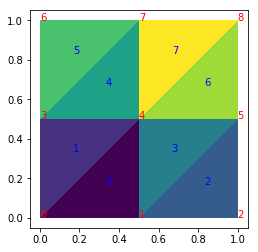

In [69]:
cell_f = CellFunction("size_t", mesh)
for cell in cells(mesh):
    cell_f[cell.index()] = cell.index()
    
p = plot(cell_f)
print p
ax = p.axes
for cell in cells(mesh):
    ax.text(cell.midpoint()[0], cell.midpoint()[1], '{}'.format(cell.index()), color='blue')
for v in vertices(mesh):
    ax.text(v.point()[0], v.point()[1], '{}'.format(v.index()), color='red')


dimension of fem space: 49
dof: 10


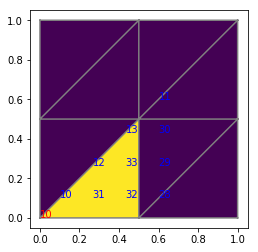

dof: 28


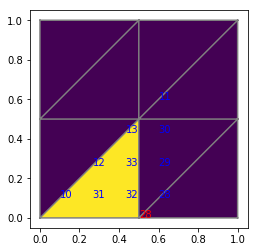

dof: 11


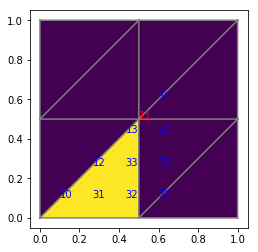

dof: 29


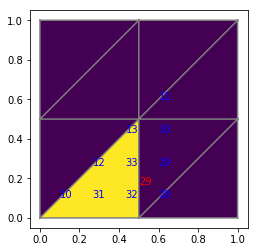

dof: 30


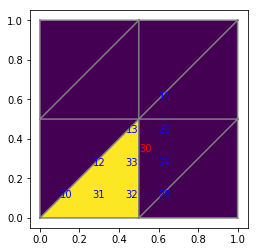

dof: 12


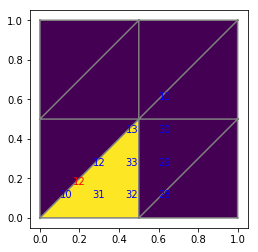

dof: 13


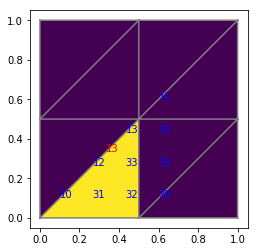

dof: 31


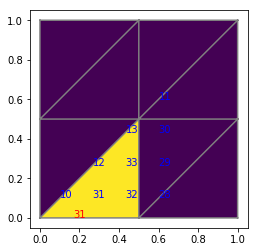

dof: 32


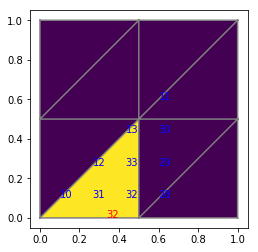

dof: 33


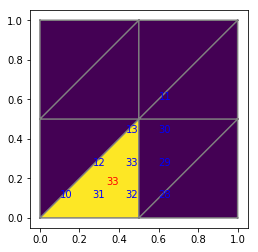

dof: 10


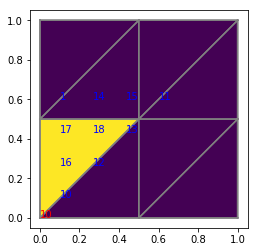

dof: 1


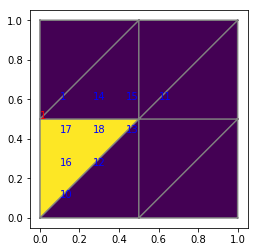

dof: 11


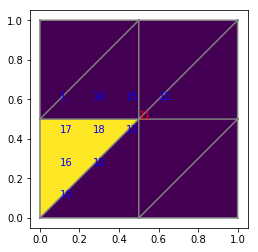

dof: 14


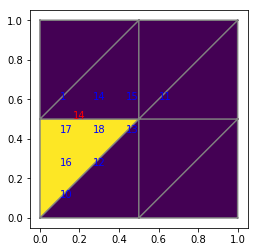

dof: 15


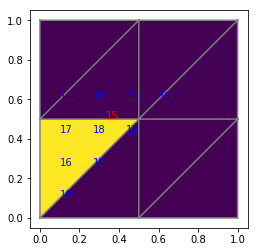

dof: 12


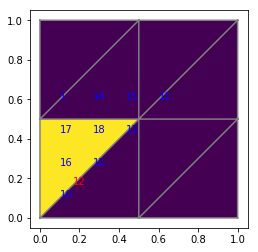

dof: 13


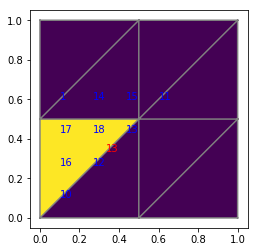

dof: 16


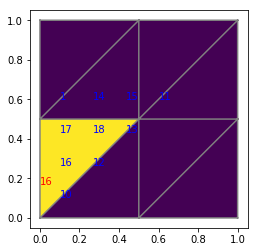

dof: 17


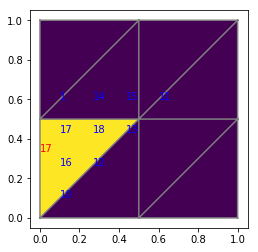

dof: 18


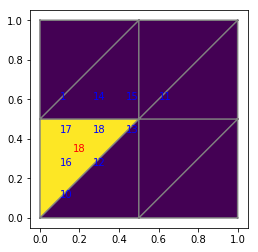

dof: 28


dof: 43


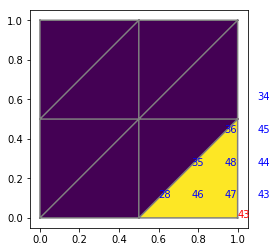

dof: 34


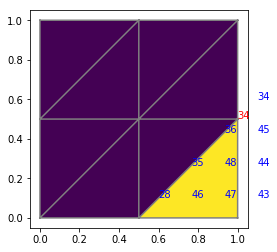

dof: 44


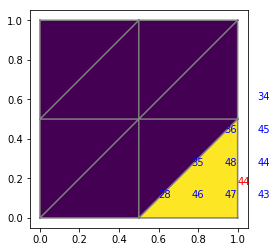

dof: 45


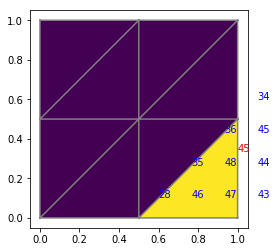

dof: 35


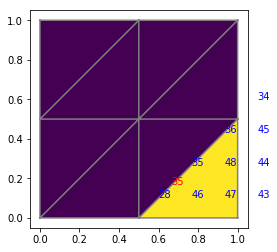

dof: 36


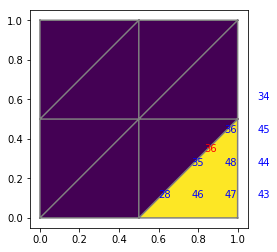

dof: 46


dof: 47


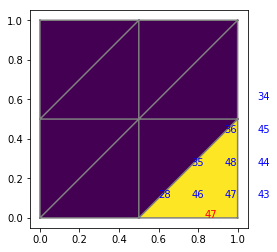

dof: 48


dof: 28


dof: 11


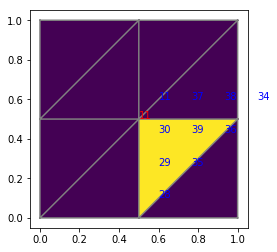

dof: 34


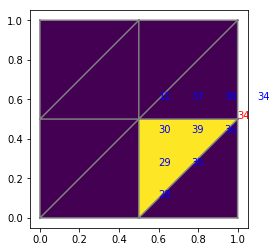

dof: 37


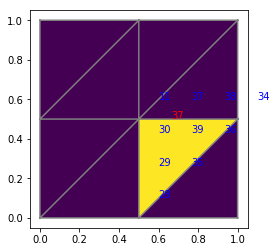

dof: 38


dof: 35


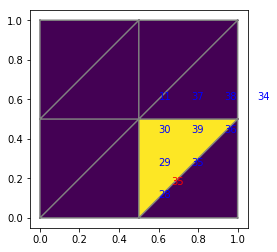

dof: 36


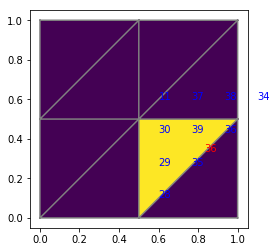

dof: 29


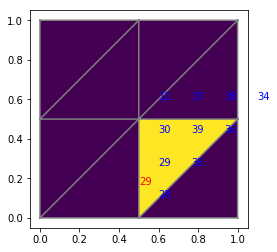

dof: 30


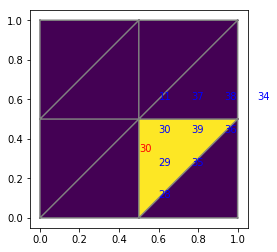

dof: 39


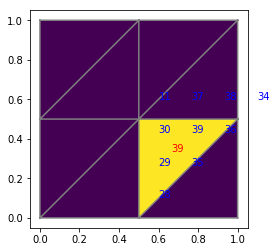

dof: 1


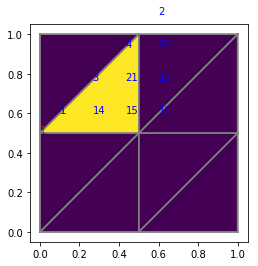

dof: 11


dof: 2


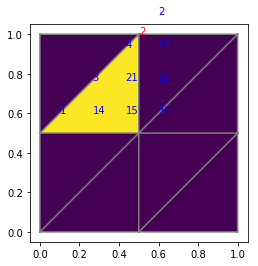

dof: 19


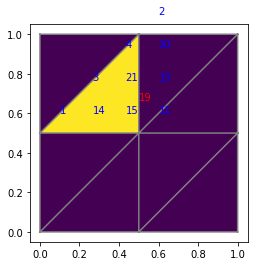

dof: 20


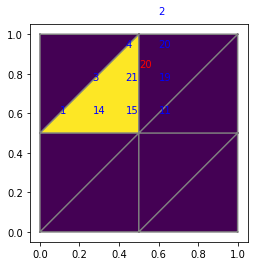

dof: 3


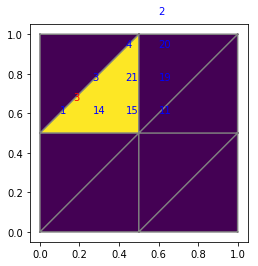

dof: 4


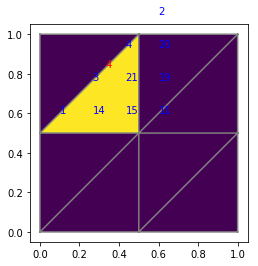

dof: 14


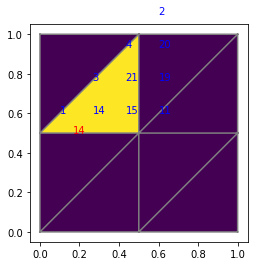

dof: 15


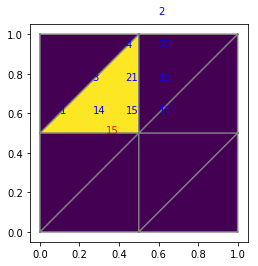

dof: 21


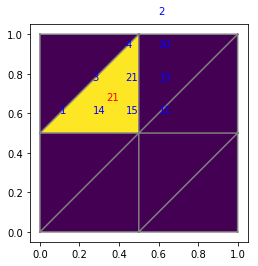

dof: 1


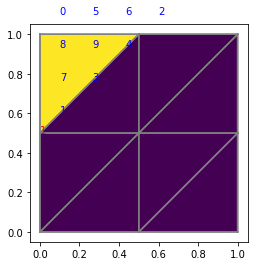

dof: 0


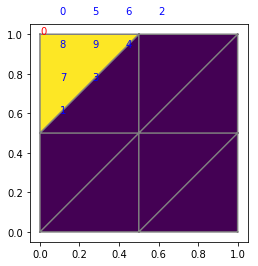

dof: 2


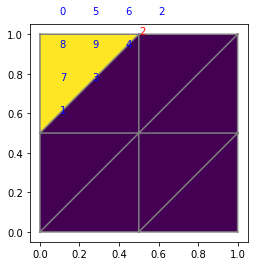

dof: 5


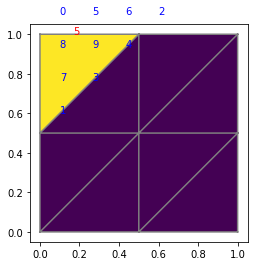

dof: 6


dof: 3


dof: 4


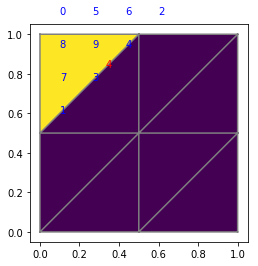

dof: 7


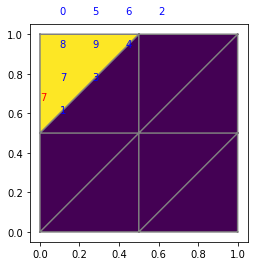

dof: 8


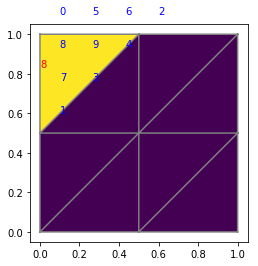

dof: 9


dof: 11


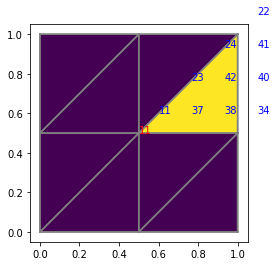

dof: 34


dof: 22


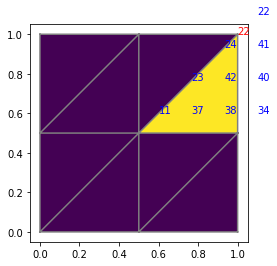

dof: 40


dof: 41


dof: 23


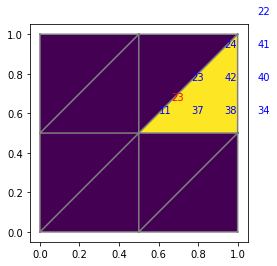

dof: 24


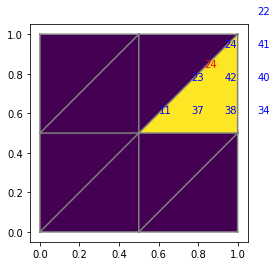

dof: 37


dof: 38


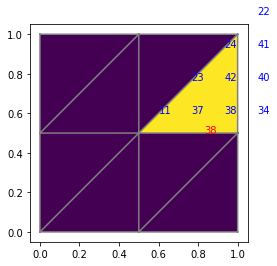

dof: 42


dof: 11


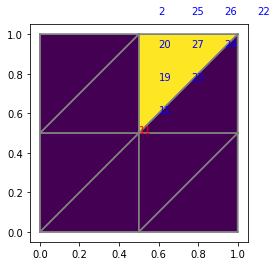

dof: 2


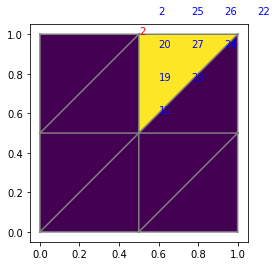

dof: 22


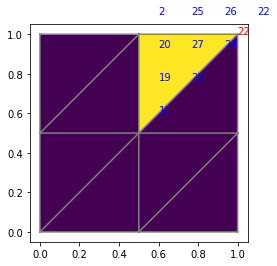

dof: 25


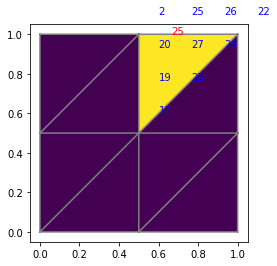

dof: 26


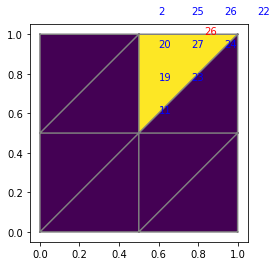

dof: 23


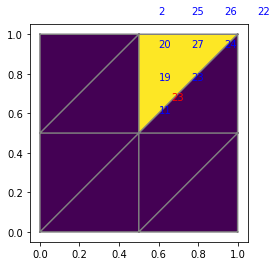

dof: 24


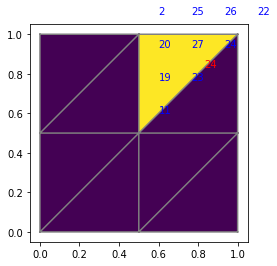

dof: 19


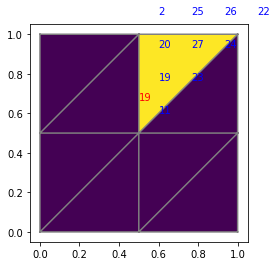

dof: 20


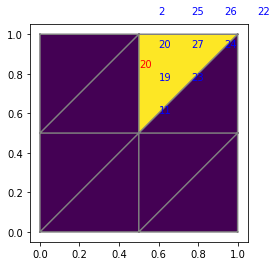

dof: 27


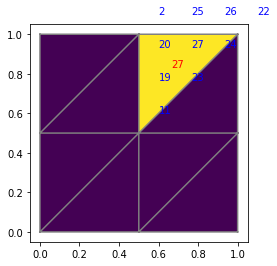

o=================================================o
|         Sorted tasks by amount of time          |
o=================================================o
| assemble                    2.183502  seconds |
| create CSR Matrix           0.072447  seconds |
| as backend type             0.017943  seconds |
| eliminate zeros             0.013458  seconds |
| get CSR Matrix              0.009115  seconds |
| append                      0.002054  seconds |
| define cell function        0.000693  seconds |
| create subdomain measure    0.000101  seconds |
o=================================================o


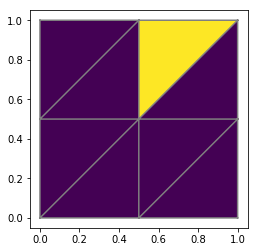

In [70]:
u = TrialFunction(V)
v = TestFunction(V)

phi_k = Function(V)
phi_l = Function(V)

dg0 = TestFunction(DG0)

result = {}

dof2patch_dofs = get_dof2patch_dof_list(V)
dm = V.dofmap()

op_list = []
d2c = V.tabulate_dof_coordinates().reshape((-1, 2))
DG0 = FunctionSpace(V.mesh(), "DG", 0)
c_fun = Function(DG0)

h = CellSize(V.mesh())

print("dimension of fem space: {}".format(V.dim()))
for lic, c in enumerate(cells(V.mesh())):
    # print("consider cell: {}".format(c.index()))
    # c_fun_vec = np.zeros(DG0.dim())
    # c_fun_vec[c.index()] = 1
    # c_fun.vector()[:] = c_fun_vec
    # plot(c_fun)
    # plot(mesh)
    # plt.show()
    with TicToc(key="define cell function", active=True, do_print=False):
        subdomain = CellFunction('size_t', V.mesh(), 0)
        subdomain[c] = 1
    plot(mesh)
    p = plot(subdomain)
    ax = p.axes
    # d_string = "dof: "
    with TicToc(key="create subdomain measure", active=True, do_print=False):
        dx = Measure('dx', subdomain_data=subdomain)
    for lia, d in enumerate(dm.cell_dofs(c.index())):
        # d_string += " {}".format(d)
        k_vec = np.zeros(V.dim())
        k_vec[d] = 1
        phi_k.vector()[:] = k_vec
        ax.text(d2c[d][0], d2c[d][1], "{}".format(d), color='red')
        for d2 in dm.cell_dofs(c.index()):
            
            ax.text(d2c[d2][0]+0.1, d2c[d2][1]+0.1, "{}".format(d2), color='blue')
            
            l_vec = np.zeros(V.dim())
            l_vec[d2] = 1
            phi_l.vector()[:] = l_vec
        
            with TicToc(key="assemble", active=True, do_print=False):
                a = assemble(h*inner(nabla_div(phi_k*nabla_grad(u)), nabla_div(phi_l * nabla_grad(v)))*dx())
            with TicToc(key="as backend type", active=True, do_print=False):
                mat = as_backend_type(a).mat()
            with TicToc(key="get CSR Matrix", active=True, do_print=False):
                row, column, data = mat.getValuesCSR()
            with TicToc(key="create CSR Matrix", active=True, do_print=False):
                sc_mat = csr_matrix((data, column, row))
            with TicToc(key="eliminate zeros", active=True, do_print=False):
                sc_mat.eliminate_zeros()
            with TicToc(key="append", do_print=False, active=True):
                assert (sc_mat.nnz > 0)
                result[(d, d2)] = sc_mat
        print("dof: {}".format(d))
        plt.show()
        plot(mesh)
        p = plot(subdomain)
        ax = p.axes
    # print d_string
TicToc.sortedTimes()
TicToc.clear()